
# Regressión LASSO


## Descripción e identificación del tipo de algoritmo

El Método Lasso (Least Absolute Shrinkage and Selection Operator), introducido por Tibshirani (1996) es un método que combina un modelo de regresión con un procedimiento de contracción de algunos parámetros hacia cero y selección de variables, imponiendo una restricción
o una penalización sobre los coeficientes de regresión.

Es un modelo lineal que penaliza el vector de coeficientes añadiendo su norma L1 (basada en la distancia Manhattan) a la función de coste:
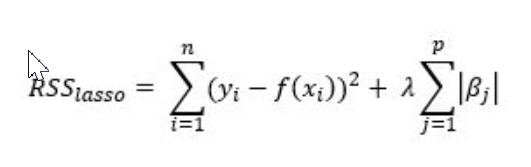

Lasso tiende a generar "coeficientes dispersos": vectores de coeficientes en los que la mayoría de ellos toman el valor cero. Esto quiere decir que el modelo va a ignorar algunas de las características predictivas, lo que puede ser considerado un tipo de selección automática de características. El incluir menos características supone un modelo más sencillo de interpretar que puede poner de manifiesto las características más importantes del conjunto de datos. En el caso de que exista cierta correlación entre las características predictivas, Lasso tenderá a escoger una de ellas al azar.

Esto significa que, aunque Ridge es una buena opción por defecto, si sospechamos que la distribución de los datos viene determinada por un subconjunto de las características predictivas, Lasso podría devolver mejores resultados.



## Relación con otros algoritmos vistos en la asignatura
La Regresión Rigde, también denominada regresión contraída o Tikhonov regularization, regulariza el modelo resultante imponiendo una penalización al tamaño de los coeficientes de la relación lineal entre las características predictivas y la variable objetivo. En este caso, los coeficientes calculados minimizan la suma de los cuadrados de los residuos penalizada al añadir el cuadrado de la norma L2 del vector formado por los coeficientes:

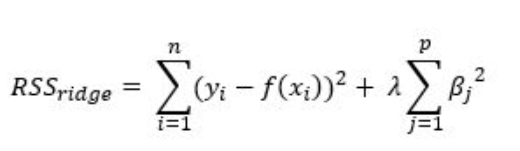

...donde λ es un parámetro que controla el grado de penalización: cuanto mayor éste, los coeficientes serán menores resultando más robustos a la colinealidad. Cuando α es igual a cero, Ridge es equivalente a la regresión lineal.

## Selección del problema a resolver
Para la resolución del problema se usará el siguiente conjunto de datos. Fuente: https://www.kaggle.com/jackdaoud/marketing-data?select=marketing_data.csv

Es un archivo CSV de 2240 observaciones (clientes) con 28 variables relacionadas con datos de marketing. Más específicamente, las variables brindan información sobre:

- Perfiles de clientes
- Productos comprados
- Éxito (o fracaso) de la campaña
- Rendimiento del canal
 

En primer lugar, vamos a descargar los datos:

## Configuración del Entorno

In [33]:
# cargamos librerías necesarias
import numpy  as np  
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])


import seaborn as sns

from sklearn.feature_selection import f_regression, mutual_info_regression

from sklearn.feature_selection import f_classif, mutual_info_classif

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score

from sklearn.preprocessing import PolynomialFeatures


## Carga y limpieza de datos

In [34]:
marketing_data = pd.read_csv("./marketing_data.csv") # cargamos fichero (le permitimos inferir automáticamente el tipo de datos en cada columna)
marketing_data                                   # visualizamos 5 primeras filas

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Complain,Country
0,1826,1970,Graduation,Divorced,"$84,835.00",0,0,6/16/14,0,189,...,6,1,0,0,0,0,0,1,0,SP
1,1,1961,Graduation,Single,"$57,091.00",0,0,6/15/14,0,464,...,7,5,0,0,0,0,1,1,0,CA
2,10476,1958,Graduation,Married,"$67,267.00",0,1,5/13/14,0,134,...,5,2,0,0,0,0,0,0,0,US
3,1386,1967,Graduation,Together,"$32,474.00",1,1,5/11/14,0,10,...,2,7,0,0,0,0,0,0,0,AUS
4,5371,1989,Graduation,Single,"$21,474.00",1,0,4/8/14,0,6,...,2,7,1,0,0,0,0,1,0,SP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10142,1976,PhD,Divorced,"$66,476.00",0,1,3/7/13,99,372,...,11,4,0,0,0,0,0,0,0,US
2236,5263,1977,2n Cycle,Married,"$31,056.00",1,0,1/22/13,99,5,...,3,8,0,0,0,0,0,0,0,SP
2237,22,1976,Graduation,Divorced,"$46,310.00",1,0,12/3/12,99,185,...,5,8,0,0,0,0,0,0,0,SP
2238,528,1978,Graduation,Married,"$65,819.00",0,0,11/29/12,99,267,...,10,3,0,0,0,0,0,0,0,IND


In [35]:
marketing_data.columns = marketing_data.columns.str.strip()
marketing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   2240 non-null   int64 
 1   Year_Birth           2240 non-null   int64 
 2   Education            2240 non-null   object
 3   Marital_Status       2240 non-null   object
 4   Income               2216 non-null   object
 5   Kidhome              2240 non-null   int64 
 6   Teenhome             2240 non-null   int64 
 7   Dt_Customer          2240 non-null   object
 8   Recency              2240 non-null   int64 
 9   MntWines             2240 non-null   int64 
 10  MntFruits            2240 non-null   int64 
 11  MntMeatProducts      2240 non-null   int64 
 12  MntFishProducts      2240 non-null   int64 
 13  MntSweetProducts     2240 non-null   int64 
 14  MntGoldProds         2240 non-null   int64 
 15  NumDealsPurchases    2240 non-null   int64 
 16  NumWeb

In [36]:
marketing_data.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,2240.0,5592.159821,3246.662198,0.0,2828.25,5458.5,8427.75,11191.0
Year_Birth,2240.0,1968.805804,11.984069,1893.0,1959.00,1970.0,1977.00,1996.0
Kidhome,2240.0,0.444196,0.538398,0.0,0.00,0.0,1.00,2.0
Teenhome,2240.0,0.506250,0.544538,0.0,0.00,0.0,1.00,2.0
Recency,2240.0,49.109375,28.962453,0.0,24.00,49.0,74.00,99.0
MntWines,2240.0,303.935714,336.597393,0.0,23.75,173.5,504.25,1493.0
MntFruits,2240.0,26.302232,39.773434,0.0,1.00,8.0,33.00,199.0
MntMeatProducts,2240.0,166.950000,225.715373,0.0,16.00,67.0,232.00,1725.0
MntFishProducts,2240.0,37.525446,54.628979,0.0,3.00,12.0,50.00,259.0
MntSweetProducts,2240.0,27.062946,41.280498,0.0,1.00,8.0,33.00,263.0


Como se mencionó anteriormente, el Dataframe consta de 2240 filas de datos ejemplo y 28 columnas que describen las variables asociadas a cada ejemplo.

In [37]:
# Eliminamos las columnas ID 
marketing_data = marketing_data.drop(['ID'], axis=1)
marketing_data.head(5)

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,...,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Complain,Country
0,1970,Graduation,Divorced,"$84,835.00",0,0,6/16/14,0,189,104,...,6,1,0,0,0,0,0,1,0,SP
1,1961,Graduation,Single,"$57,091.00",0,0,6/15/14,0,464,5,...,7,5,0,0,0,0,1,1,0,CA
2,1958,Graduation,Married,"$67,267.00",0,1,5/13/14,0,134,11,...,5,2,0,0,0,0,0,0,0,US
3,1967,Graduation,Together,"$32,474.00",1,1,5/11/14,0,10,0,...,2,7,0,0,0,0,0,0,0,AUS
4,1989,Graduation,Single,"$21,474.00",1,0,4/8/14,0,6,16,...,2,7,1,0,0,0,0,1,0,SP


In [38]:
#En este problema no se aplicarán dummies a country ya que no aporta nada valor al momento de 
#aplicar filtrado de características que se verá más adelante
#marketing_data = pd.get_dummies(marketing_data, columns=['Country'], drop_first=False)
list(marketing_data.columns)

['Year_Birth',
 'Education',
 'Marital_Status',
 'Income',
 'Kidhome',
 'Teenhome',
 'Dt_Customer',
 'Recency',
 'MntWines',
 'MntFruits',
 'MntMeatProducts',
 'MntFishProducts',
 'MntSweetProducts',
 'MntGoldProds',
 'NumDealsPurchases',
 'NumWebPurchases',
 'NumCatalogPurchases',
 'NumStorePurchases',
 'NumWebVisitsMonth',
 'AcceptedCmp3',
 'AcceptedCmp4',
 'AcceptedCmp5',
 'AcceptedCmp1',
 'AcceptedCmp2',
 'Response',
 'Complain',
 'Country']

Se procede a renombrar las columnas, por comidad se dejará la variable objetivo en la primera columna.

In [44]:

marketing_data = marketing_data[['NumWebPurchases','Year_Birth', 'Education', 'Marital_Status', 'Kidhome', 'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'NumStorePurchases' ,'MntFruits',
 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumCatalogPurchases', 'NumWebVisitsMonth', 'AcceptedCmp3',
 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Response', 'Complain', 'Country', 'Income']]

marketing_data

,NumWebPurchases,Year_Birth,Education,Marital_Status,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,NumStorePurchases,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Complain,Country,Income
0,4,1970,Graduation,Divorced,0,0,6/16/14,0,189,6,...,1,0,0,0,0,0,1,0,SP,"$84,835.00"
1,7,1961,Graduation,Single,0,0,6/15/14,0,464,7,...,5,0,0,0,0,1,1,0,CA,"$57,091.00"
2,3,1958,Graduation,Married,0,1,5/13/14,0,134,5,...,2,0,0,0,0,0,0,0,US,"$67,267.00"
3,1,1967,Graduation,Together,1,1,5/11/14,0,10,2,...,7,0,0,0,0,0,0,0,AUS,"$32,474.00"
4,3,1989,Graduation,Single,1,0,4/8/14,0,6,2,...,7,1,0,0,0,0,1,0,SP,"$21,474.00"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,5,1976,PhD,Divorced,0,1,3/7/13,99,372,11,...,4,0,0,0,0,0,0,0,US,"$66,476.00"
2236,1,1977,2n Cycle,Married,1,0,1/22/13,99,5,3,...,8,0,0,0,0,0,0,0,SP,"$31,056.00"
2237,6,1976,Graduation,Divorced,1,0,12/3/12,99,185,5,...,8,0,0,0,0,0,0,0,SP,"$46,310.00"
2238,5,1978,Graduation,Married,0,0,11/29/12,99,267,10,...,3,0,0,0,0,0,0,0,IND,"$65,819.00"


A continuación, usando la columna años de nacimiento `Yeart_Birth` se calculará la edad de cada cliente. 
Se asignará el valor calculado a la nueva columna `years_old`

In [45]:
# convertimos la variable Year Birth en Edad
marketing_data['years_old'] = pd.Timestamp('now').year - marketing_data['Year_Birth']
marketing_data.head(5)

,NumWebPurchases,Year_Birth,Education,Marital_Status,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,NumStorePurchases,...,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Complain,Country,Income,years_old
0,4,1970,Graduation,Divorced,0,0,6/16/14,0,189,6,...,0,0,0,0,0,1,0,SP,"$84,835.00",51
1,7,1961,Graduation,Single,0,0,6/15/14,0,464,7,...,0,0,0,0,1,1,0,CA,"$57,091.00",60
2,3,1958,Graduation,Married,0,1,5/13/14,0,134,5,...,0,0,0,0,0,0,0,US,"$67,267.00",63
3,1,1967,Graduation,Together,1,1,5/11/14,0,10,2,...,0,0,0,0,0,0,0,AUS,"$32,474.00",54
4,3,1989,Graduation,Single,1,0,4/8/14,0,6,2,...,1,0,0,0,0,1,0,SP,"$21,474.00",32


## Análisis exploratorio de los datos
Cargamos los datos, los visualizamos y hacemos un análisis exploratorio de los mismos.

In [46]:
marketing_data.describe().T

,count,mean,std,min,25%,50%,75%,max
NumWebPurchases,2240.0,4.084821,2.778714,0.0,2.00,4.0,6.00,27.0
Year_Birth,2240.0,1968.805804,11.984069,1893.0,1959.00,1970.0,1977.00,1996.0
Kidhome,2240.0,0.444196,0.538398,0.0,0.00,0.0,1.00,2.0
Teenhome,2240.0,0.506250,0.544538,0.0,0.00,0.0,1.00,2.0
Recency,2240.0,49.109375,28.962453,0.0,24.00,49.0,74.00,99.0
MntWines,2240.0,303.935714,336.597393,0.0,23.75,173.5,504.25,1493.0
NumStorePurchases,2240.0,5.790179,3.250958,0.0,3.00,5.0,8.00,13.0
MntFruits,2240.0,26.302232,39.773434,0.0,1.00,8.0,33.00,199.0
MntMeatProducts,2240.0,166.950000,225.715373,0.0,16.00,67.0,232.00,1725.0
MntFishProducts,2240.0,37.525446,54.628979,0.0,3.00,12.0,50.00,259.0


Después, podemos realizar graficos de algunas variables respecto a la variable objetivo, para tener una mejor perspectiva.

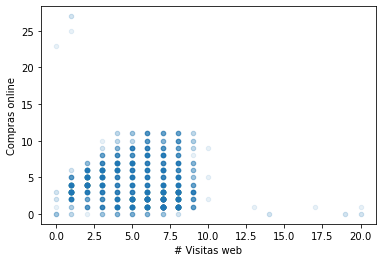

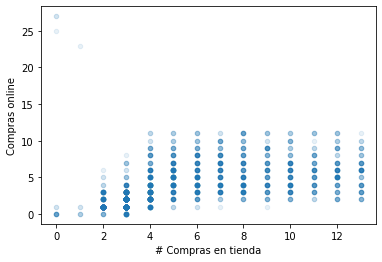

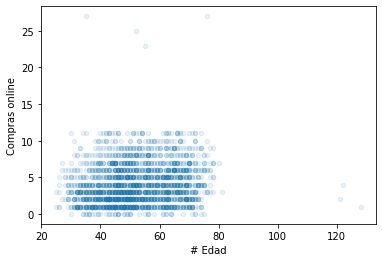

In [47]:
# La utilización de transparencia (alpha) puede ser útil para apreciar la densidad de los datos con tres variables
marketing_data.plot(kind = 'scatter', x='NumWebVisitsMonth', y = 'NumWebPurchases', alpha=0.1)
plt.xlabel('# Visitas web')
plt.ylabel('Compras online')
plt.show()

marketing_data.plot(kind = 'scatter', x='NumStorePurchases', y = 'NumWebPurchases', alpha=0.1)
plt.xlabel('# Compras en tienda')
plt.ylabel('Compras online')
plt.show()

marketing_data.plot(kind = 'scatter', x='years_old', y = 'NumWebPurchases', alpha=0.1)
plt.xlabel('# Edad')
plt.ylabel('Compras online')
plt.show()


Personas menores de 80 años

In [48]:
# por el momento vamos a centrarnos en personas menores de 80 años
sel = marketing_data.years_old <= 80

print(marketing_data.shape)
marketing_data = marketing_data[sel]
print(marketing_data.shape)
marketing_data

(2240, 28)
(2236, 28)


,NumWebPurchases,Year_Birth,Education,Marital_Status,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,NumStorePurchases,...,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Complain,Country,Income,years_old
0,4,1970,Graduation,Divorced,0,0,6/16/14,0,189,6,...,0,0,0,0,0,1,0,SP,"$84,835.00",51
1,7,1961,Graduation,Single,0,0,6/15/14,0,464,7,...,0,0,0,0,1,1,0,CA,"$57,091.00",60
2,3,1958,Graduation,Married,0,1,5/13/14,0,134,5,...,0,0,0,0,0,0,0,US,"$67,267.00",63
3,1,1967,Graduation,Together,1,1,5/11/14,0,10,2,...,0,0,0,0,0,0,0,AUS,"$32,474.00",54
4,3,1989,Graduation,Single,1,0,4/8/14,0,6,2,...,1,0,0,0,0,1,0,SP,"$21,474.00",32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,5,1976,PhD,Divorced,0,1,3/7/13,99,372,11,...,0,0,0,0,0,0,0,US,"$66,476.00",45
2236,1,1977,2n Cycle,Married,1,0,1/22/13,99,5,3,...,0,0,0,0,0,0,0,SP,"$31,056.00",44
2237,6,1976,Graduation,Divorced,1,0,12/3/12,99,185,5,...,0,0,0,0,0,0,0,SP,"$46,310.00",45
2238,5,1978,Graduation,Married,0,0,11/29/12,99,267,10,...,0,0,0,0,0,0,0,IND,"$65,819.00",43


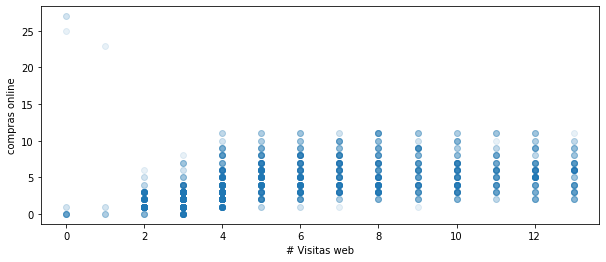

In [49]:
plt.figure(figsize = (10,4))
plt.scatter(marketing_data.NumStorePurchases, marketing_data.NumWebPurchases, alpha=0.1)
plt.xlabel('# Visitas web')
plt.ylabel('compras online')
plt.show()

Calculamos la matriz de correlación:

In [64]:
marketing_data.corr() # matriz de correlación

,NumWebPurchases,Kidhome,Teenhome,Recency,MntWines,NumStorePurchases,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,NumCatalogPurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Complain,years_old
NumWebPurchases,1.000000,-0.362275,0.155649,-0.010339,0.542140,0.502232,0.296947,0.293498,0.293410,0.348235,...,0.378049,-0.056276,0.041911,0.155692,0.138916,0.154952,0.034084,0.148390,-0.013250,0.154622
Kidhome,-0.362275,1.000000,-0.036109,0.008148,-0.496643,-0.500701,-0.372826,-0.437436,-0.387890,-0.370990,...,-0.502761,0.447662,0.014505,-0.161908,-0.205132,-0.172638,-0.081849,-0.080346,0.036254,-0.233575
Teenhome,0.155649,-0.036109,1.000000,0.017803,0.005213,0.050300,-0.176277,-0.261195,-0.204247,-0.162538,...,-0.110551,0.134463,-0.042949,0.038680,-0.190383,-0.140426,-0.015715,-0.154941,0.007553,0.364947
Recency,-0.010339,0.008148,0.017803,1.000000,0.017024,0.001518,-0.003115,0.024236,0.002031,0.023536,...,0.025878,-0.021876,-0.032792,0.019108,0.001160,-0.019079,-0.001680,-0.198388,0.005470,0.017915
MntWines,0.542140,-0.496643,0.005213,0.017024,1.000000,0.642392,0.388435,0.561934,0.398989,0.385909,...,0.634741,-0.320382,0.062146,0.373497,0.471942,0.354332,0.206027,0.247325,-0.035952,0.163793
NumStorePurchases,0.502232,-0.500701,0.050300,0.001518,0.642392,1.000000,0.463082,0.480022,0.460009,0.448713,...,0.518816,-0.429950,-0.068063,0.179090,0.216097,0.182994,0.085075,0.038755,-0.011549,0.140276
MntFruits,0.296947,-0.372826,-0.176277,-0.003115,0.388435,0.463082,1.000000,0.541961,0.594356,0.566970,...,0.487221,-0.417509,0.014902,0.010319,0.211969,0.195324,-0.009736,0.125798,-0.002828,0.014503
MntMeatProducts,0.293498,-0.437436,-0.261195,0.024236,0.561934,0.480022,0.541961,1.000000,0.567786,0.523319,...,0.723472,-0.539308,0.018244,0.102977,0.372172,0.310052,0.043058,0.236543,-0.020752,0.031757
MntFishProducts,0.293410,-0.387890,-0.204247,0.002031,0.398989,0.460009,0.594356,0.567786,1.000000,0.579468,...,0.533953,-0.445849,0.000284,0.016779,0.198101,0.260859,0.002548,0.111302,-0.018849,0.043342
MntSweetProducts,0.348235,-0.370990,-0.162538,0.023536,0.385909,0.448713,0.566970,0.523319,0.579468,1.000000,...,0.490413,-0.423330,0.001408,0.028532,0.258795,0.241825,0.009939,0.117259,-0.020434,0.020325


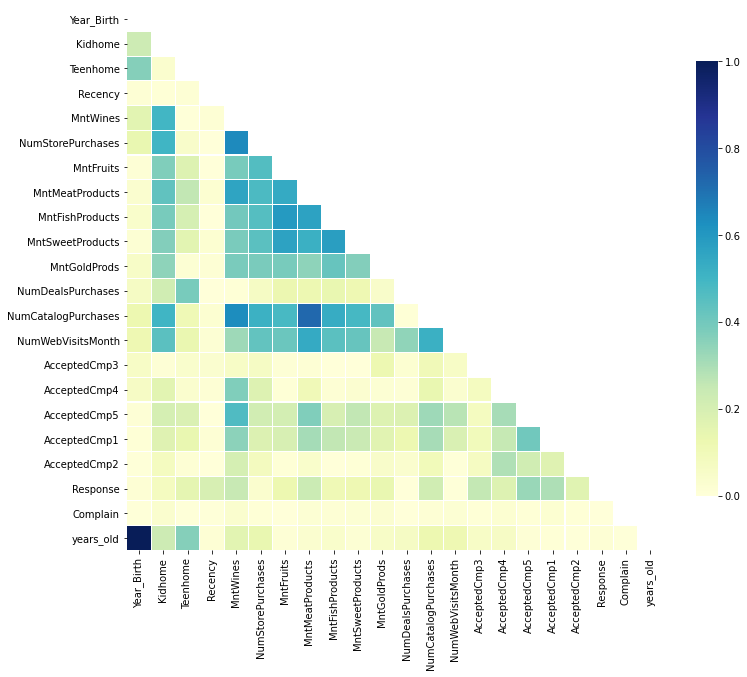

In [51]:
# Compute the correlation matrix
corr = np.abs(marketing_data.drop(['NumWebPurchases'], axis=1).corr())

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

Una vez tenemos esta información, es el momento de pensar sobre otras variables que tengan sentido, y de eliminar variables con alta correlación. Algunos ejemplos:

- Eliminar `Year_Birth`
- Utilizar el atributo edad, `years_old`, en lugar del año de nacimiento 
- Se podría eliminar `MntMeatProducts` sin embargo esta bajo el 0,8 de correlación

In [52]:
marketing_data = marketing_data.drop(['Year_Birth','Education','Marital_Status','Income','Dt_Customer','Country'], axis=1)
marketing_data.head(5)

,NumWebPurchases,Kidhome,Teenhome,Recency,MntWines,NumStorePurchases,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,NumCatalogPurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Complain,years_old
0,4,0,0,0,189,6,104,379,111,189,...,4,1,0,0,0,0,0,1,0,51
1,7,0,0,0,464,7,5,64,7,0,...,3,5,0,0,0,0,1,1,0,60
2,3,0,1,0,134,5,11,59,15,2,...,2,2,0,0,0,0,0,0,0,63
3,1,1,1,0,10,2,0,1,0,0,...,0,7,0,0,0,0,0,0,0,54
4,3,1,0,0,6,2,16,24,11,0,...,1,7,1,0,0,0,0,1,0,32


## SELECCIÓN DE CARACTERÍSTICAS 


## mutual_info_regression

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


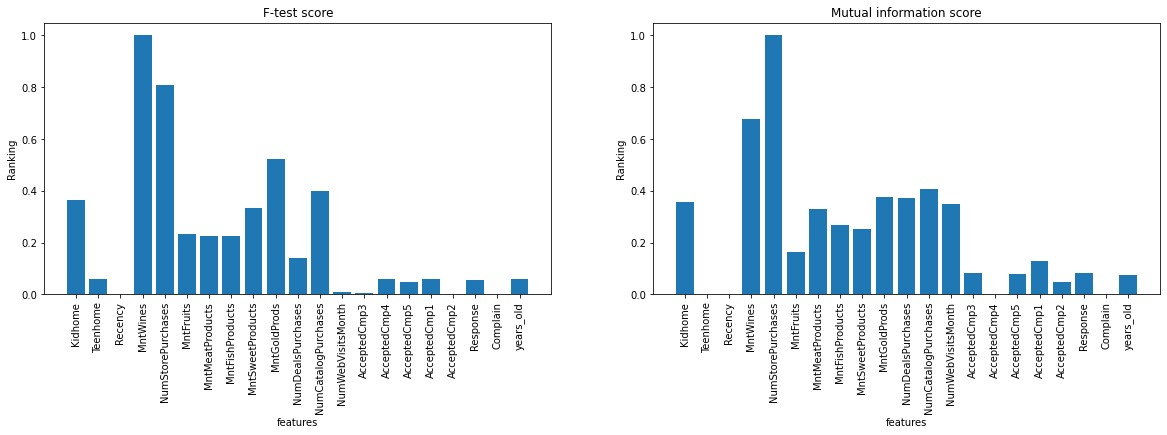

In [67]:
# convertimos el DataFrame al formato necesario para scikit-learn
data = marketing_data.to_numpy()

y = data[:, 0]     # nos quedamos con la 1ª columna, compras por internet
X = data[:,1:]      # nos quedamos con el resto

feature_names = marketing_data.columns[1:]

# do calculations
f_test, _ = f_regression(X, y)
f_test /= np.max(f_test)

mi = mutual_info_regression(X, y)
mi /= np.max(mi)

# do some plotting
plt.figure(figsize=(20, 5))

plt.subplot(1,2,1)
plt.bar(range(X.shape[1]), f_test,  align="center")
plt.xticks(range(X.shape[1]), feature_names, rotation = 90)
plt.xlabel('features')
plt.ylabel('Ranking')
plt.title('F-test score')

plt.subplot(1,2,2)
plt.bar(range(X.shape[1]), mi, align="center")
plt.xticks(range(X.shape[1]), feature_names, rotation = 90)
plt.xlabel('features')
plt.ylabel('Ranking')
plt.title('Mutual information score')

plt.show()

In [68]:
# creamos un vector con la variable objetivo

#data = marketing_data.to_numpy()

target_var = 'NumWebPurchases'
y = marketing_data[target_var].values.copy()

feature_vars = ['MntWines', 'NumStorePurchases', 'MntGoldProds']

# creamos la matriz de features
X = marketing_data[feature_vars].values.copy()

In [69]:
# importamos el modelo que vamos a utilizar
from sklearn.linear_model import Lasso

# creamos el estimador instanciando la clase del modelo
# - para comenzar, pondremos poca regularización (alpha muy bajo)
# - permitiremos un intercepto
# - no normalizaremos las variables

alpha = 1e-6
est = Lasso(alpha=alpha, fit_intercept=True, normalize=False, random_state=42)

In [70]:
# importamos función para dividir el conjunto de datos
from sklearn.model_selection import train_test_split
# separamos nuestros datos en conjunto de entrenamiento y conjunto de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # fijamos un estado aleatorio para garantizar la reproducibilidad de los resultados

# ajustamos el modelo a los datos de entrenamiento
est.fit(X_train, y_train)

pd.Series(est.coef_, index=feature_vars)

MntWines             0.002742
NumStorePurchases    0.162430
MntGoldProds         0.013067
dtype: float64

In [71]:
# evaluamos el modelo en ambos conjuntos según la métrica por defecto, R2 
# (también conocida como coeficiente de determinación)
# https://en.wikipedia.org/wiki/Coefficient_of_determination
# Nótese que esta métrica es genérica y no tiene por qué corresponder a la optimizada
# por el algoritmo en el método fit
print('Métrica R2 en entrenamiento:', est.score(X_train, y_train))
print('Métrica R2 en test:', est.score(X_test, y_test))

Métrica R2 en entrenamiento: 0.3788032785263683
Métrica R2 en test: 0.3440463852952289


In [72]:
# 1. predecir
y_pred_train = est.predict(X_train)
y_pred_test = est.predict(X_test)

# 2. importar la métrica/s a evaluar
from sklearn.metrics import mean_squared_error

# 3. evaluar las métricas sobre las predicciones
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print('Métrica MSE en entrenamiento:', mse_train)
print('Métrica MSE en test:', mse_test)

# También podemos conseguir los resultados del método score anteriormente utilizado.
# Importamos la métrica R2
from sklearn.metrics import r2_score
# Evaluamos
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
print('Métrica R2 en entrenamiento:', r2_train)
print('Métrica R2 en test:', r2_test)

Métrica MSE en entrenamiento: 4.815210191860908
Métrica MSE en test: 4.994295986871413
Métrica R2 en entrenamiento: 0.3788032785263683
Métrica R2 en test: 0.3440463852952289



El criterio lineal da fuerza a tres variables  
  - Cantidad de vinos gastada en los últilos dos años. `MntWines`
  - Número de compras en la tienda física. `NumStorePurchases`
  - Cantidad de compras de productos gold. `MntGoldProds`
  
Por su parte, el criterio no lineal identifica las mismas 
  - `NumStorePurchases` 
  - `MntWine` y añade:
  - `NumCatalogPurchases`
  
En este sentido un alto `MI` sugiere una relación no lineal - por otro lado `F-Score` siguiere una relación Lineal.

En EDA el comportamiento de datos nos da a entender que estas variables se apegan a una relación lineal, se procede a ejecutar un modelo acorde a este escenario.

In [73]:
# importamos el validador 
from sklearn.model_selection import cross_validate

n_folds = 4 # vamos a hacer validación cruzada K-fold en este número de folds

# evaluamos la calidad del ajuste de modelo de acuerdo a unas métricas de score
# están implementadas muchas métricas
# https://scikit-learn.org/stable/modules/model_evaluation.html#the-scoring-parameter-defining-model-evaluation-rules
# recuerda que esta métrica no tiene por qué coincidir con la función de coste/pérdida optimizada por el algoritmo
# elegimos las mismas que anteriormente con la salvedad de que el MSE está cambiado de signo
scoring = ['neg_mean_squared_error', 'r2']
cv_results = cross_validate(est, X, y, cv=n_folds, return_train_score=True, return_estimator=True, scoring=scoring)
cv_results

{'fit_time': array([0.02070308, 0.00314808, 0.00296545, 0.00315833]),
 'score_time': array([0.00158358, 0.00139189, 0.00154996, 0.00148058]),
 'estimator': (Lasso(alpha=1e-06, copy_X=True, fit_intercept=True, max_iter=1000,
     normalize=False, positive=False, precompute=False, random_state=42,
     selection='cyclic', tol=0.0001, warm_start=False),
  Lasso(alpha=1e-06, copy_X=True, fit_intercept=True, max_iter=1000,
     normalize=False, positive=False, precompute=False, random_state=42,
     selection='cyclic', tol=0.0001, warm_start=False),
  Lasso(alpha=1e-06, copy_X=True, fit_intercept=True, max_iter=1000,
     normalize=False, positive=False, precompute=False, random_state=42,
     selection='cyclic', tol=0.0001, warm_start=False),
  Lasso(alpha=1e-06, copy_X=True, fit_intercept=True, max_iter=1000,
     normalize=False, positive=False, precompute=False, random_state=42,
     selection='cyclic', tol=0.0001, warm_start=False)),
 'test_neg_mean_squared_error': array([-6.54920826, 

In [74]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler();
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

est.fit(X_train_scaled, y_train)

print('Métrica R2 en entrenamiento:', est.score(X_train_scaled, y_train))
print('Métrica R2 en test:', est.score(X_test_scaled, y_test))

Métrica R2 en entrenamiento: 0.3788032785261852
Métrica R2 en test: 0.34404646775736963


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


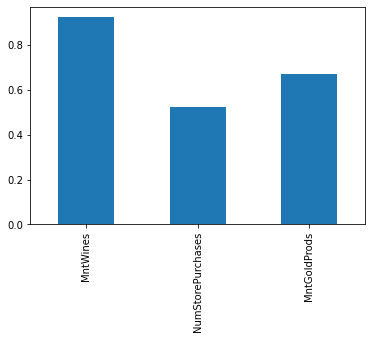

In [75]:
# Dibujamos los coeficientes
pd.Series(est.coef_, index=feature_vars).plot.bar();

In [76]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

est2 = Pipeline([('scaler', scaler), ('lasso', est)])

alpha_arr = np.logspace(-6, -2, 20)
param_grid = {'lasso__alpha': alpha_arr}

n_folds = 5

scoring = ['neg_mean_squared_error', 'r2'] # evaluar varias métricas en cada fold
scoring_refit = 'r2'  # elegir el mejor modelo de acuerdo a este criterio

est3 = GridSearchCV(est2, param_grid, scoring=scoring, cv=n_folds, refit=scoring_refit, return_train_score=True)

est3.fit(X, y)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packag

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lasso', Lasso(alpha=1e-06, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=42,
   selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'lasso__alpha': array([1.00000e-06, 1.62378e-06, 2.63665e-06, 4.28133e-06, 6.95193e-06,
       1.12884e-05, 1.83298e-05, 2.97635e-05, 4.83293e-05, 7.84760e-05,
       1.27427e-04, 2.06914e-04, 3.35982e-04, 5.45559e-04, 8.85867e-04,
       1.43845e-03, 2.33572e-03, 3.79269e-03, 6.15848e-03, 1.00000e-02])},
       pre_dispatch='2*n_jobs', refit='r2', return_train_score=True,
       scoring=['neg_mean_squared_error', 'r2'], verbose=0)

Best alpha: 0.01


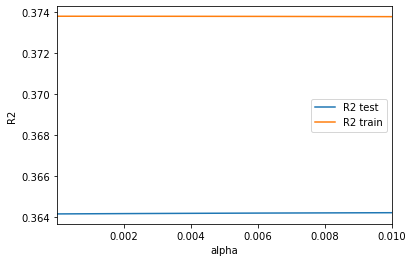

In [77]:
alpha_arr 

est3.cv_results_['mean_train_r2']
est3.cv_results_['mean_test_r2']

est3.cv_results_['mean_test_neg_mean_squared_error']
est3.cv_results_['mean_train_neg_mean_squared_error']

_ = plt.plot(alpha_arr, est3.cv_results_['mean_test_r2'], label='R2 test')
_ = plt.plot(alpha_arr, est3.cv_results_['mean_train_r2'], label='R2 train')
_ = plt.xlim([1e-8, 1e-2]);
_ = plt.xlabel('alpha')
_ = plt.ylabel('R2')
_ = plt.legend(loc='best')


best_alpha = est3.best_params_['lasso__alpha']
print('Best alpha: {:.4g}'.format(best_alpha))

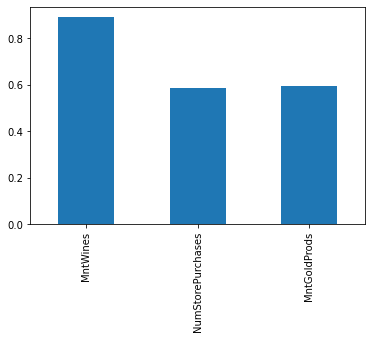

In [78]:
coefs = est3.best_estimator_.named_steps['lasso'].coef_
pd.Series(coefs, index=feature_vars).plot.bar();

In [79]:
from sklearn.linear_model import Lasso, LinearRegression

def train_algo(seed, algo):
    np.random.seed(seed=seed)  # Fijamos el estado del generador de números aleatorios
    scale_factors = np.random.rand(X_train.shape[1])  # Generamos unos factores de escala diferentes para cada variable
    X_train_scaled = X_train*scale_factors  # Escalamos las variables multiplicando por los factores
        
    if algo=="Lasso":
        alpha = 3e-4
        est = Lasso(alpha=alpha, fit_intercept=True, normalize=False, random_state=42) # sí le afecta la escala
    elif algo=="LinearRegression":
        est = LinearRegression(fit_intercept=True, normalize=False) # no le afecta la escala

    est.fit(X_train_scaled, y_train)
    r2_train = est.score(X_train_scaled, y_train)
    print('Métrica R2 en entrenamiento:', r2_train)
    

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

widget_seed = widgets.IntSlider(min=0, max=100, step=1, value=42, continuous_update=False, description='Semilla:')

widget_algo = widgets.Dropdown(value='Lasso', placeholder='Elige algoritmo',
    options=['Lasso', 'LinearRegression'],
    description='Algoritmo:',
    ensure_option=True,
    disabled=False
)

print("""A continuación se muestran varios controles interactivos:
- "Semilla": variando este parámetro se consiguen generar diferentes escalados aleatorios de las variables
- "Algoritmo": permite seleccionar el algoritmo sobre el que evaluar la invariancia a la escala""")
interact(train_algo, algo=widget_algo, seed=widget_seed);

A continuación se muestran varios controles interactivos:
- "Semilla": variando este parámetro se consiguen generar diferentes escalados aleatorios de las variables
- "Algoritmo": permite seleccionar el algoritmo sobre el que evaluar la invariancia a la escala


interactive(children=(IntSlider(value=42, continuous_update=False, description='Semilla:'), Dropdown(descripti…

In [82]:
best_est = est3.best_estimator_
best_est.fit(X, y)
y_pred = best_est.predict(X)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [83]:
mpg_pred = 1/y_pred
results = pd.DataFrame({'fuel_consumption': data['fuel_consumption'],
             'fuel_consumption_pred': y_pred,
              'mpg': data['mpg'],
              'mpg_pred': mpg_pred
             })
results

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices